# This notebook presents a guide on using VQE with the VQALib

This notebook presents a walkthrough through defining an MDISS problem instance and solving it using VQE. The functions used to find solutions and define the problems are defined in the VQALib.py file.

In [1]:
from VQALib import IsingHamiltonian

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter

from VQALib import CubicProgram, IsingHamiltonian

from qiskit.visualization import plot_histogram

# ------------ GRAPH FUNCTIONS -----------
def draw_graph(G, colors, pos, ax=None):
    default_axes = plt.axes(frameon=True) if ax is None else ax
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def compute_matrix(n, G):
    # Computing the weight matrix from the random graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def color_graph(bitstring, n, m, H, posH, ax=None):
    #print(bitstring)
    colors = ["r" for node in range(m)]
    for k in range(n*m):
        i = k // m  # Integer division to retrieve the i value
        j = k % m   # Modulus operation to retrieve the j value
        if bitstring[k] == 1:
            #print(f"coloring {j}!")
            colors[j] = "b"
    draw_graph(H, colors, posH, ax)

def create_graph(n, elistG, m, elistH):
    # Target graph:
    H = nx.DiGraph()
    H.add_nodes_from(np.arange(0, m, 1))
    H.add_edges_from(elistH)
    colorsH = ["r" for node in H.nodes()]
    posH = nx.spring_layout(H)

    # Pattern graph:
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(0, n, 1))
    G.add_edges_from(elistG)
    colorsG = ["r" for node in G.nodes()]
    posG = nx.spring_layout(H)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    draw_graph(G, colorsG, posG, axes[0])
    draw_graph(H, colorsH, posH, axes[1])
    plt.tight_layout()
    plt.show()

    return G, colorsG, posG, H, colorsH, posH

# ------------ ARITHMETIC FUNCTIONS ------
def expand_arithmetic_function(mat1, mat2, n, m):
    linear = []
    quadratic = []
    cubic = []

    penalty = n

    def translate(i, j):
        return (i*m+j)

    # FIRST TERM:
    sum = 0
    for i in range(n):
        for u in range(m):
            linear.append((translate(i, u), -1))

    # SECOND TERM (EXPANDED):
    sum2 = 0
    for v in range(m):
        inner = 0
        for i in range(n):
            for k in range(n):
                quadratic.append( ( (translate(i, v), translate(k, v) ), 1) )   # ( (var1, var2),  coeff )
        
        for i in range(n):
            linear.append((translate(i, v), -1))
    

    sum2 = 0
    # THIRD TERM (CHECKS THAT NUMBER OF OUTGOING EDGES OF EACH VERTEX U IS EQUAL TO OUTGOING EDGES OF EACH VERTEX I):
    for u in range(m):
        for i in range(n):
            for j in range(n):
                # Add the linear terms:
                linear.append((translate(i, u), penalty*mat1[i][j]*mat1[i][j]))

                for v in range(m):
                    # Add quadratic terms:
                    quadratic.append( ( (translate(j,v), translate(i, u) ), -1*2*penalty*mat1[i][j]*mat2[u][v]) )
                
                for v in range(m):
                    for k in range(m):
                        # Add cubic terms:
                        cubic.append( ( ( translate(j,v), translate(j, k), translate(i,u) ), penalty*mat2[u][v]*mat2[u][k] ) )
            

    # FOURTH TERM (CHECKS THAT NUMBER OF INCOMING EDGES OF EACH VERTEX U IS EQUAL TO OUTGOING EDGES OF EACH VERTEX I):
    for u in range(m):
        for i in range(n):
            for j in range(n):
                # Add the linear terms:
                linear.append((translate(i, u), penalty*mat1[j][i]*mat1[j][i]))

                for v in range(m):
                    # Add quadratic terms:
                    quadratic.append( ( (translate(j,v), translate(i, u) ), -1*2*penalty*mat1[j][i]*mat2[v][u]) )
                
                for v in range(m):
                    for k in range(m):
                        # Add cubic terms:
                        cubic.append( ( ( translate(j,v), translate(j, k), translate(i,u) ), penalty*mat2[v][u]*mat2[k][u] ) )
    
    return linear, quadratic, cubic

def clean_coefficients(linear, quadratic, cubic):
    """Removes all the terms with coefficient 0 from the function.

    Args:
        linear (_type_): linear terms
        quadratic (_type_): quadratic_terms
        cubic (_type_): cubic terms
    """    
    def drop(list):
        to_remove = []
        for idx, (term, coeff) in enumerate(list):
            if coeff == 0:
                to_remove.append((term, coeff))
        
        for item in to_remove:
            list.remove(item)
        return list
    
    linear = drop(linear)
    quadratic = drop(quadratic)
    cubic = drop(cubic)
    
    return linear, quadratic, cubic

def collect_terms(linear, quadratic, cubic):
    """Sums all identical terms together to reduce function to strictly unique terms with real coefficient.
    """    
    def combine(tuple_list):
        combined_tuples = {}
        
        for tpl, coeff in tuple_list:
            # Convert the tuple to a hashable format using sorted tuple of its Counter elements
            if isinstance(tpl, int):
                tpl = (tpl,)
            hashable_tpl = tuple(sorted(Counter(tpl).items()))
            # Check if the hashable tuple already exists in the dictionary
            if hashable_tpl in combined_tuples:
                # Accumulate the coefficient for the existing tuple
                combined_tuples[hashable_tpl] += coeff
            else:
                # Create a new entry in the dictionary
                combined_tuples[hashable_tpl] = coeff
        
        # Convert the dictionary back to the original format of list of tuples
        reduced_list = [( tuple(x for x, count in dict_key for _ in range(count)) , coeff) for dict_key, coeff in combined_tuples.items()]
        
        return reduced_list

    
    collected_linear_terms = combine(linear)
    collected_quadratic_terms = combine(quadratic)
    collected_cubic_terms = combine(cubic)

    return collected_linear_terms, collected_quadratic_terms, collected_cubic_terms

def produce_terms_from_graphs(mat1, mat2, n, m):
    linear, quadratic, cubic = expand_arithmetic_function(mat1, mat2, n, m)
    linear, quadratic, cubic = clean_coefficients(linear, quadratic, cubic)
    linear, quadratic, cubic = collect_terms(linear, quadratic, cubic)
    #print(f"Size: {len(linear)}, linear terms: {linear}")
    #print(f"Size: {len(quadratic)}, quadratic terms: {quadratic}")
    #print(f"Size: {len(cubic)}, cubic terms: {cubic}")
    return linear, quadratic, cubic

def produce_cubic_problem_from_graph(n, elistG, m, elistH):
    G, colorsG, posG, H, colorsH, posH = create_graph(n, elistG, m, elistH)
    linear, quadratic, cubic = produce_terms_from_graphs(compute_matrix(n, G), compute_matrix(m, H), n, m)
    cubic_instance = CubicProgram(linear, quadratic, cubic, n*m)
    return cubic_instance, n, m, H, posH

First we define some helper functions to run experiments

In [2]:
import timeit
def run_experiment(n, elistG, m, elistH, VQE=False, QAOA=False, correct_bitstrings='', runs=20):
    overlaps = []
    timing = []
    bitstrings = []
    avg_overlap = 0
    avg_timing = 0
    cubic_instance, n, m, H, posH = produce_cubic_problem_from_graph(n, elistG, m, elistH)
    for i in range(runs):
        hamiltonian = IsingHamiltonian(cubic_instance)

        # Time the function execution
        start_time = timeit.default_timer()
        if VQE:
            likeliest_bitstring, highest_probability, overlap = hamiltonian.run_VQE(correct_bitstrings=correct_bitstrings, depth=4)
        elif QAOA:
            likeliest_bitstring, highest_probability, overlap = hamiltonian.run_QAOA_custom(correct_bitstrings=correct_bitstrings)
        else:
            likeliest_bitstring, overlap = hamiltonian.run_numpy_eigensolver()
        end_time = timeit.default_timer()
        
        timing.append(end_time - start_time)
        overlaps.append(overlap)
        bitstrings.append(likeliest_bitstring)
        print(likeliest_bitstring)
    
    avg_overlap = np.average(overlaps)
    avg_timing = np.average(timing)
    print(f"Iteration overlaps: {overlaps}")
    print(f"Iteration timings: {timing}")
    print(f"Average overlap: {avg_overlap}, Average timing: {avg_timing}")

    # Create subplots based on the number of graphs
    num_graphs = len(bitstrings)
    num_rows = 3  # You can adjust the layout based on your preference
    num_cols = 3

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    # Flatten the axes array if necessary
    axes = axes.flatten()
    for i, likeliest_bitstring in enumerate(bitstrings):
        # Determine the subplot for the current graph
        if num_graphs > 1:
            ax = axes[i]
        else:
            ax = axes
        color_graph(likeliest_bitstring[::-1], n, m, H, posH, ax)
        
        if overlaps[i] >= 0.9:
            ax.text(0.5, 0.95, f'Correct', transform=ax.transAxes,
                    fontsize=15, va='top', ha='center', bbox=dict(facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.95, f'Wrong', transform=ax.transAxes,
                    fontsize=15, va='top', ha='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()

    # Display the subplots
    plt.show()

We use the VQATests.py file and the MDISS problems defined there.

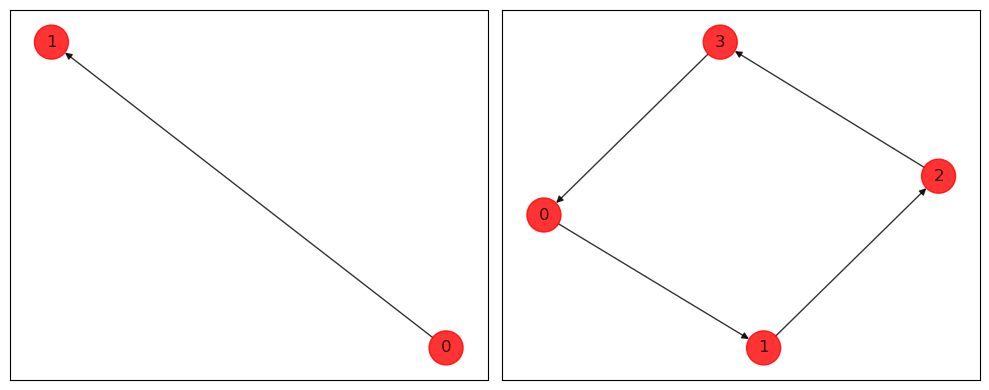

In [3]:
from VQATests import tests
test_pkg = tests()
problem1 = test_pkg.problems[8][2]

n1 = problem1['n']
m1 = problem1['m']
elistG1 = problem1['elistG']
elistH1 = problem1['elistH']
cubic_instance1, n1, m1, H1, posH1 = produce_cubic_problem_from_graph(n1, elistG1, m1, elistH1)
hamiltonian1 = IsingHamiltonian(cubic_instance1)

Having coverted the problem to an IsingHamiltonian, we can now solve it with the .run_vqe() method

1.0


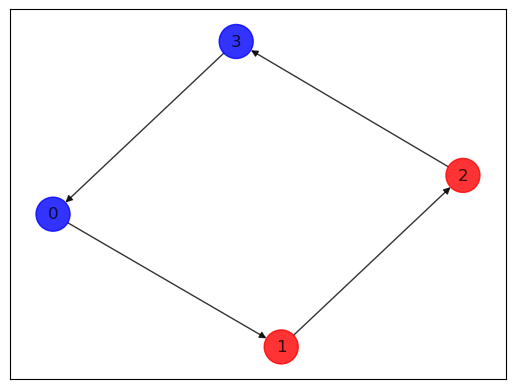

In [4]:
correct_bitstrings1 = problem1['correct_bitstrings']
likeliest_bitstring1, highest_probability1, overlap1 = hamiltonian1.run_VQE(correct_bitstrings1, depth=3)
counts1 = hamiltonian1.counts
print(overlap1)
color_graph(likeliest_bitstring1[::-1], n1, m1, H1, posH1)

Moving on to another example

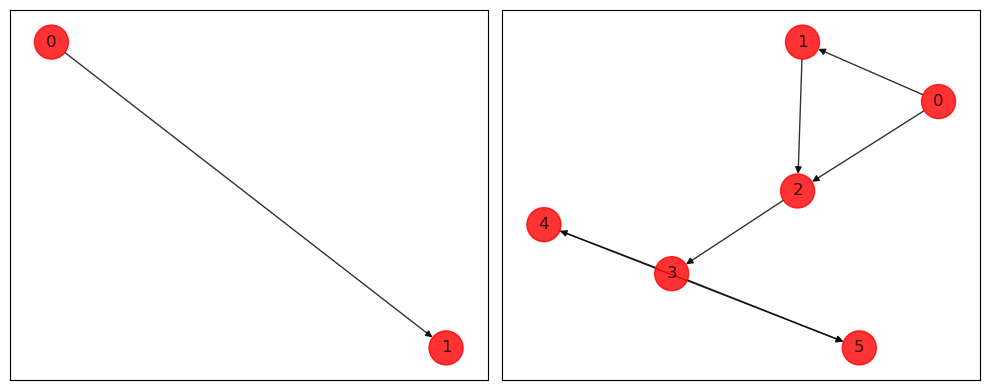

In [14]:
problem3 = test_pkg.problems[12][1]

n3 = problem3['n']
m3 = problem3['m']
elistG3 = problem3['elistG']
elistH3 = problem3['elistH']
cubic_instance3, n3, m3, H3, posH3 = produce_cubic_problem_from_graph(n3, elistG3, m3, elistH3)
hamiltonian3 = IsingHamiltonian(cubic_instance3)

0


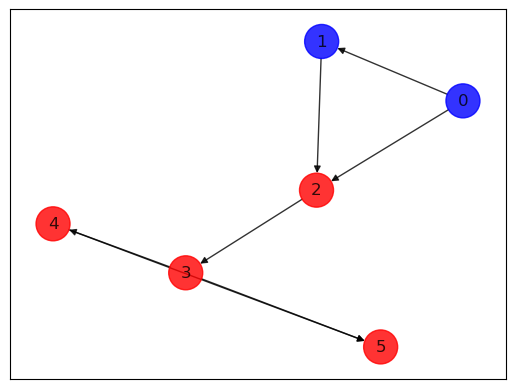

In [15]:
correct_bitstrings3 = problem3['correct_bitstrings']
likeliest_bitstring3, highest_probability3, overlap3 = hamiltonian3.run_VQE(correct_bitstrings3, depth=2)
counts3 = hamiltonian3.counts

print(overlap3)
color_graph(likeliest_bitstring3, n3, m3, H3, posH3)

We now use the "run_experiments()" function we defined earlier to rerun VQE on the same problem many times to get a performance estimation

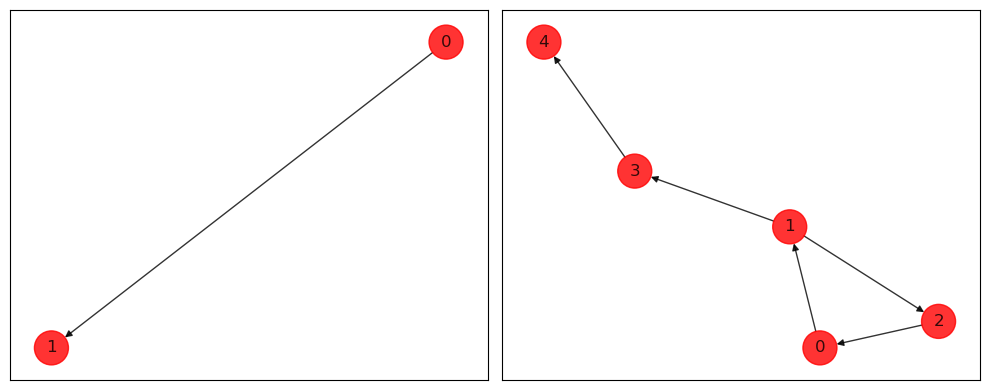

[1, 0, 0, 0, 1, 0, 1, 1, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
Iteration overlaps: [1.0, 0, 0, 0, 0, 0, 0, 0, 0]
Iteration timings: [40.54042509999999, 69.67462920000253, 40.14069759999984, 47.98299950000364, 44.75267129999702, 43.49617769999895, 32.88846220000414, 39.905160700000124, 70.61539099999936]
Average overlap: 0.1111111111111111, Average timing: 47.77740158888951


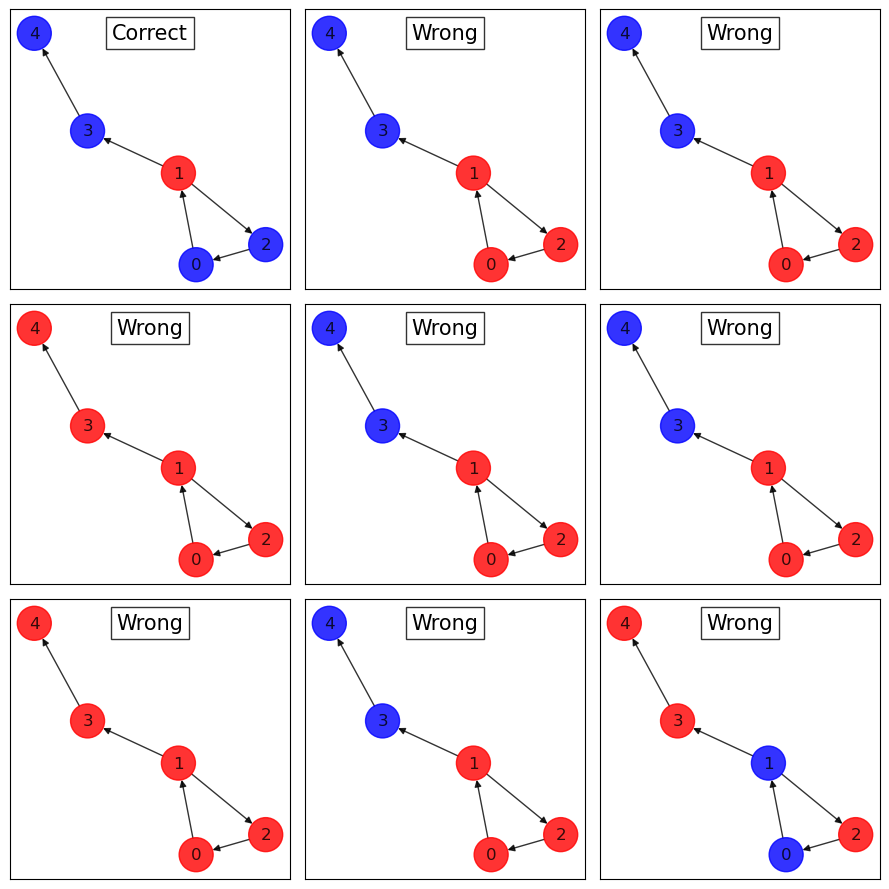

In [9]:
run_experiment(n2, elistG2, m2, elistH2, VQE=True, correct_bitstrings=correct_bitstrings2, runs=9)

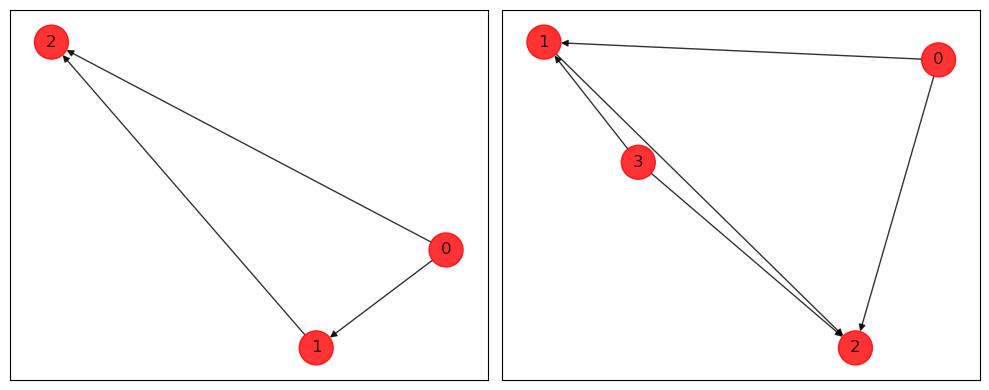

In [14]:
problem4 = test_pkg.problems[12][2]

n4 = problem4['n']
m4 = problem4['m']
elistG4 = problem4['elistG']
elistH4 = problem4['elistH']
cubic_instance4, n4, m4, H4, posH4 = produce_cubic_problem_from_graph(n4, elistG4, m4, elistH4)
hamiltonian4 = IsingHamiltonian(cubic_instance4)

1.0


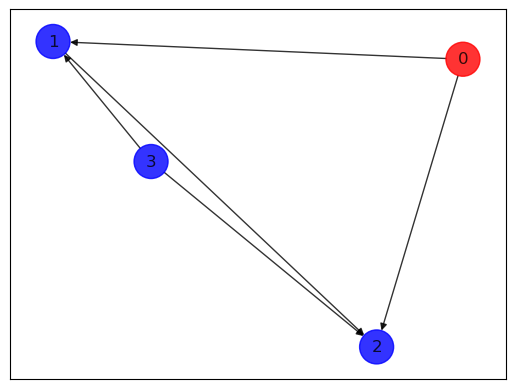

In [15]:
correct_bitstrings4 = problem4['correct_bitstrings']
likeliest_bitstring4, highest_probability4, overlap4 = hamiltonian4.run_VQE(correct_bitstrings4, depth=4)
counts4 = hamiltonian4.counts

print(overlap4)
color_graph(likeliest_bitstring4, n4, m4, H4, posH4)

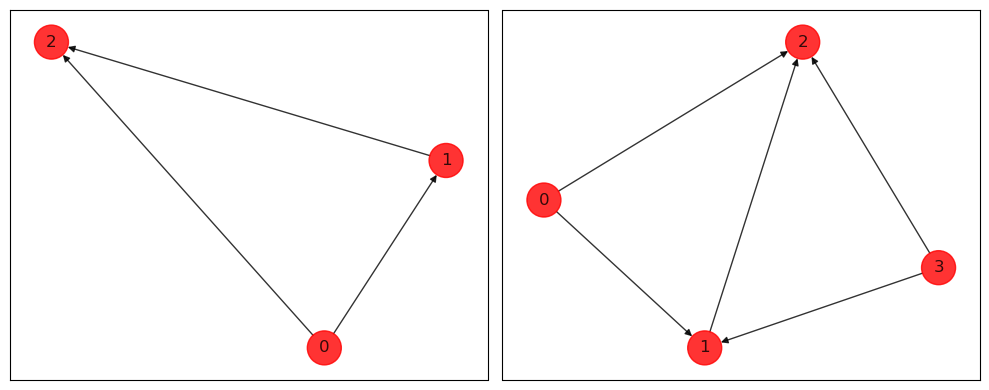

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


c:\Users\Alexander's Laptop\Documents\Computing Stuff\Quantum\.conda\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Iteration overlaps: [1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0]
Iteration timings: [37.012977699982, 24.222245499957353, 22.670257599966135, 35.438099700026214, 25.03150129999267, 31.777531799976714, 31.83013979997486, 32.268616000015754, 35.407147499965504, 32.86018130002776]
Average overlap: 0.2, Average timing: 30.851869819988497


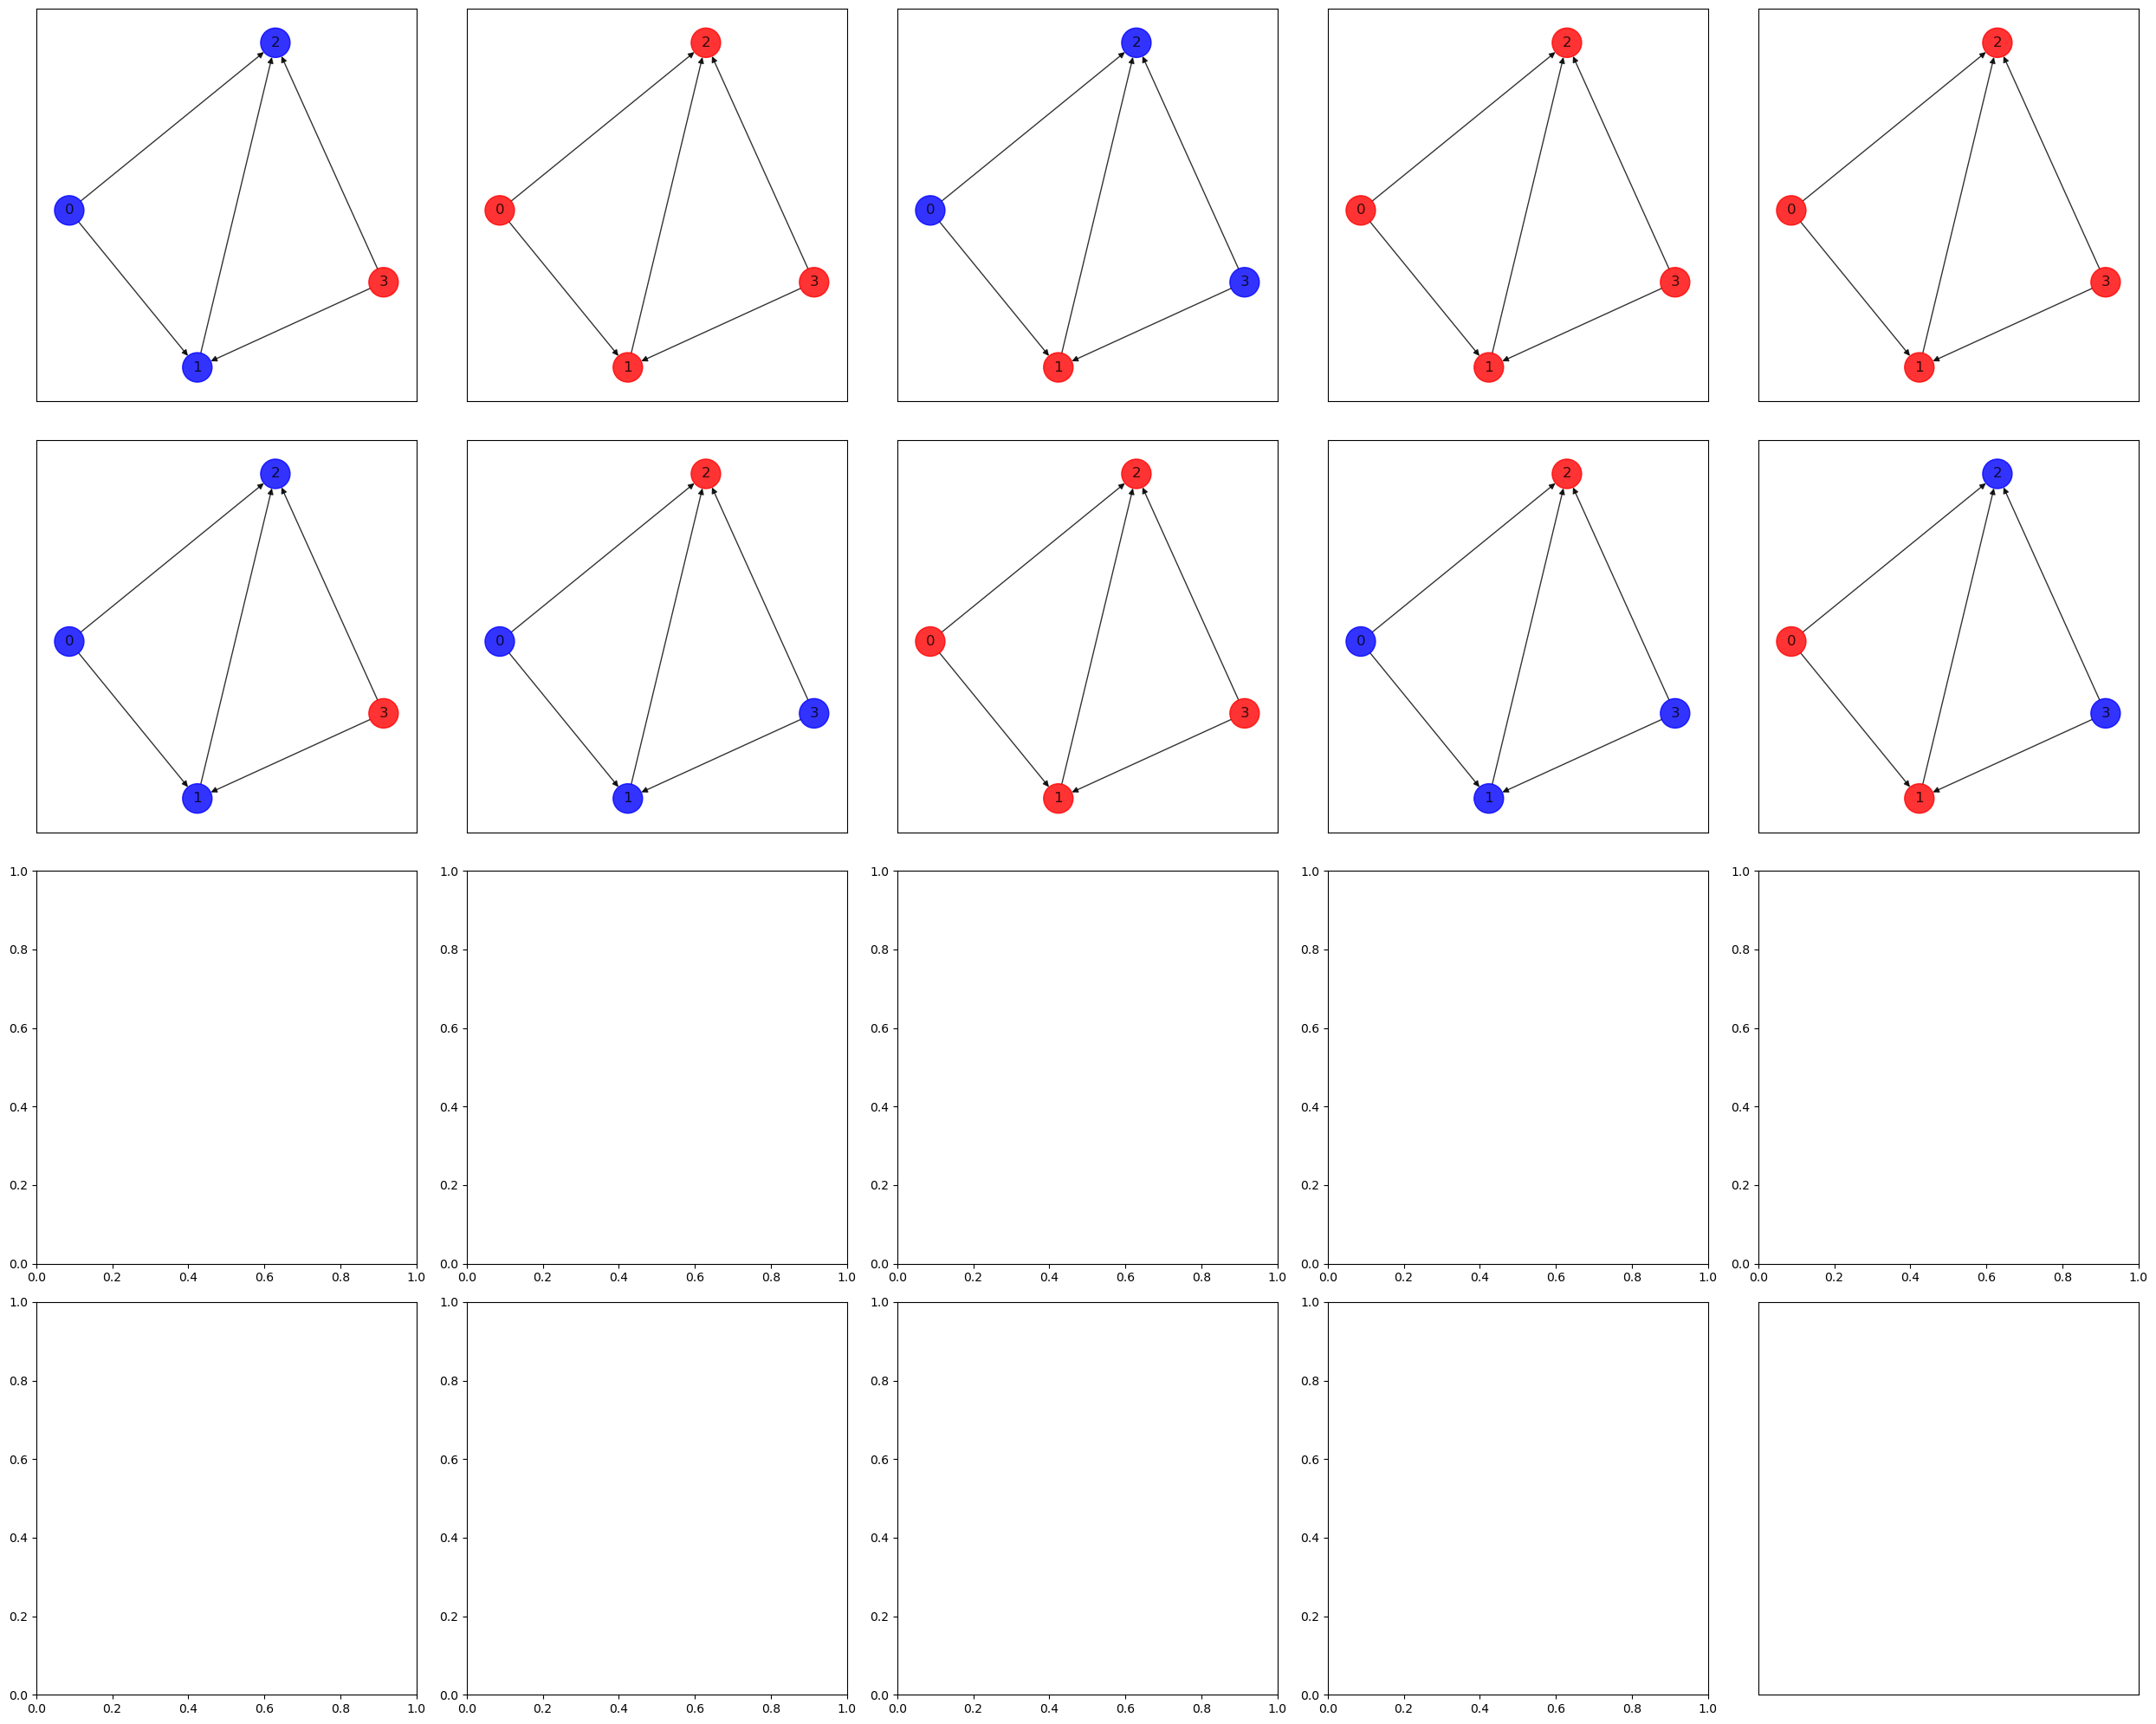

In [29]:
run_experiment(n4, elistG4, m4, elistH4, VQE=True, correct_bitstrings=correct_bitstrings4, runs=10)

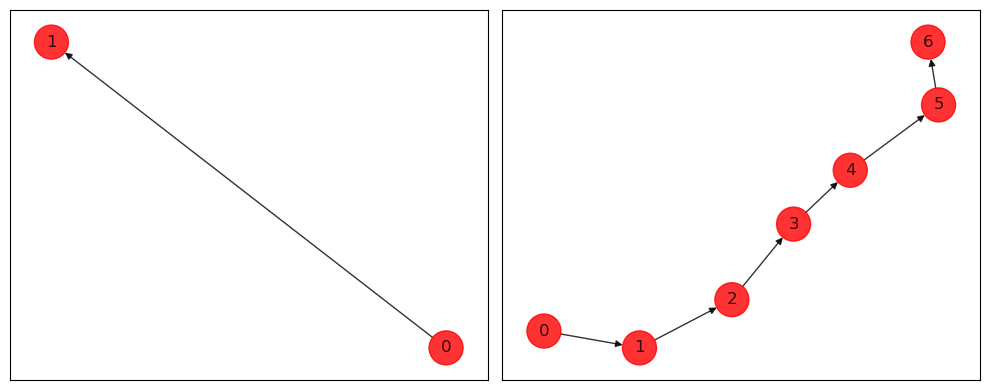

In [16]:
problem5 = test_pkg.problems[14][0]

n5 = problem5['n']
m5 = problem5['m']
elistG5 = problem5['elistG']
elistH5 = problem5['elistH']
cubic_instance5, n5, m5, H5, posH5 = produce_cubic_problem_from_graph(n5, elistG5, m5, elistH5)
hamiltonian5 = IsingHamiltonian(cubic_instance5)

1.0


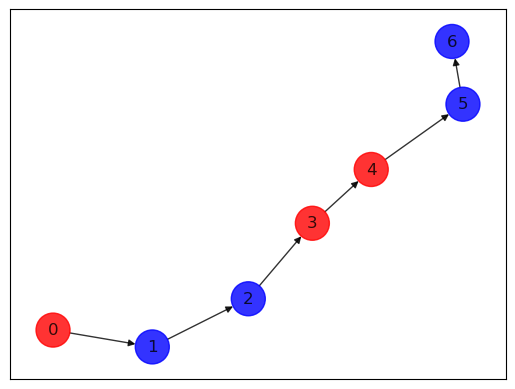

In [17]:
correct_bitstrings5 = problem5['correct_bitstrings']
likeliest_bitstring5, highest_probability5, overlap5 = hamiltonian5.run_VQE(correct_bitstrings5, depth=4)
counts5 = hamiltonian5.counts

print(overlap5)
color_graph(likeliest_bitstring5, n5, m5, H5, posH5)

In [18]:
hamiltonian5.correct_prob

1.0

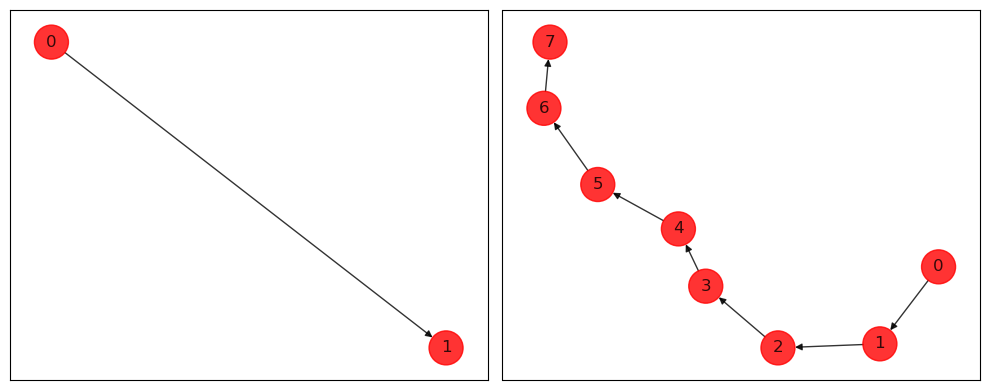

In [19]:
problem6 = test_pkg.problems[16][0]

n6 = problem6['n']
m6 = problem6['m']
elistG6 = problem6['elistG']
elistH6 = problem6['elistH']
cubic_instance6, n6, m6, H6, posH6 = produce_cubic_problem_from_graph(n6, elistG6, m6, elistH6)
hamiltonian6 = IsingHamiltonian(cubic_instance6)

In [21]:
correct_bitstrings6 = problem6['correct_bitstrings']
likeliest_bitstring6, highest_probability6, overlap6 = hamiltonian6.run_VQE(correct_bitstrings6, depth=4)
counts6 = hamiltonian6.counts

print(overlap6)
color_graph(likeliest_bitstring6, n6, m6, H6, posH6)

KeyboardInterrupt: 

: 